# Imports

## Installation of libraries

In [1]:
%pip install transformers -q
%pip install tqdm -q

     |████████████████████████████████| 5.5 MB 4.0 MB/s 
     |████████████████████████████████| 7.6 MB 20.1 MB/s 
     |████████████████████████████████| 163 kB 21.6 MB/s 


## Importation of usual libraries


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt

# Set up the model

## Importation of the GPT2 tokenizer and model 

In [3]:
""" I import a model gpt2 pretrained model. The model is on the training mode, 
so gpt2 tries to predict each word from the precedent words."""
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

from transformers import AutoModelForSequenceClassification
model = GPT2Model.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

## Implementation of the layer scrapping

In [4]:
NB_LAYERS = 11 

output_saving = []
index = []

"""We define the hook to retrieve the different output of each block. The hook 
will be automatically appeal and each output will be append to the 
output_saving list. To garantee the possibility to decode the output we have 
to apply the last layer norm."""
for k in range(NB_LAYERS):

  def forward_hook(self, input, output):
    # Tensor of size (1, SEQ_LEN, TOKEN_ID)
    output_saving.append(model.ln_f(output[0]))


  model.h[k].register_forward_hook(forward_hook)
  index.append(f'gpt block {k}')

### BONUS : illustration of the model architecture

In [5]:
"""architecture of the model"""
#list(model.modules())

'architecture of the model'

# Implementation of the algorithm

## Run the test

In [6]:
input = "What is the capital of the US"

"""we tokenize the word"""
encoded_input = tokenizer.encode(input, return_tensors='pt')

"""I don't need to keep the result of the last layer because this layer 
puts often ',' as a precaution"""
model(*encoded_input) 
"""the hook is activated during the evaluation of the model"""

'the hook is activated during the evaluation of the model'

## Decode algorithm implementation

In [7]:
def decode(output):
  """This function decodes the tokens and projets them into the words space"""
  W = model.wte.weight
  W_t = torch.transpose(W, 0, 1)
  final, logits = [], []
  for i in range(output.shape[0]):
    aux = output[i]@W_t
    final.append(torch.argmax(aux))
    logits.append(torch.max(output[i]).item())

  for i in range(len(final)):
    final[i] = tokenizer.decode(final[i])
  return final, logits

## Shape the results

In [8]:
"""sentence_shattered is the list of the different tokens of the input"""
sentence_shattered = tokenizer.encode(input)
for i in range(len(sentence_shattered)):
  sentence_shattered[i] = tokenizer.decode(sentence_shattered[i])

"""I stock the differents decoded words in words_df and their logits in 
logits_df"""
words_df, logits_df = [sentence_shattered], [[0]*len(sentence_shattered)]
for i, element in enumerate(tqdm(output_saving[:])):
  final, logits = decode(element[0])
  words_df.append(final)
  logits_df.append(logits)

"""I shape the data in a pandas dataframe """
index.insert(0, "sentence")
words_df = pd.DataFrame(words_df, index=index)
logits_df = pd.DataFrame(logits_df, index=index)
words_df = words_df.dropna(axis=1)
logits_df = logits_df.dropna(axis=1)

100%|██████████| 11/11 [00:01<00:00,  9.69it/s]


# Data analysis

## Logits dataframe

In [9]:
logits_df

,0,1,2,3,4,5,6
sentence,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt block 0,7.787462,20.594513,9.138568,24.357695,9.559299,6.387348,9.397331
gpt block 1,7.040924,18.778166,7.534872,23.300247,6.357446,8.246294,7.242647
gpt block 2,6.761999,17.837879,8.612438,30.378376,8.686580,12.181510,17.720240
gpt block 3,6.818307,23.713839,11.395821,37.030491,10.413383,15.532322,23.015656
gpt block 4,6.862739,30.430954,19.140562,36.668694,12.113029,15.560987,24.589489
gpt block 5,6.930362,32.779774,21.728615,37.152084,8.199759,13.397869,21.074200
gpt block 6,7.022958,34.188282,24.558947,43.888027,7.270880,13.949028,28.208420
gpt block 7,7.173609,44.923492,32.673634,45.391575,5.735794,20.303862,24.776602
gpt block 8,7.284205,53.881325,50.814537,42.364552,15.902967,18.179041,25.080923


## Output words dataframe

In [10]:
words_df

,0,1,2,3,4,5,6
sentence,What,is,the,capital,of,the,US
gpt block 0,the,still,same,capital,the,same,US
gpt block 1,the,still,same,capital,the,same,Army
gpt block 2,the,really,same,capital,the,same,Army
gpt block 3,the,really,difference,capital,the,same,National
gpt block 4,the,really,difference,capital,the,world,National
gpt block 5,the,really,difference,capital,the,world,National
gpt block 6,the,really,difference,difference,the,world,Embassy
gpt block 7,the,happening,best,ization,the,world,Dollar
gpt block 8,the,the,difference,ization,the,world,?


## Data visualization

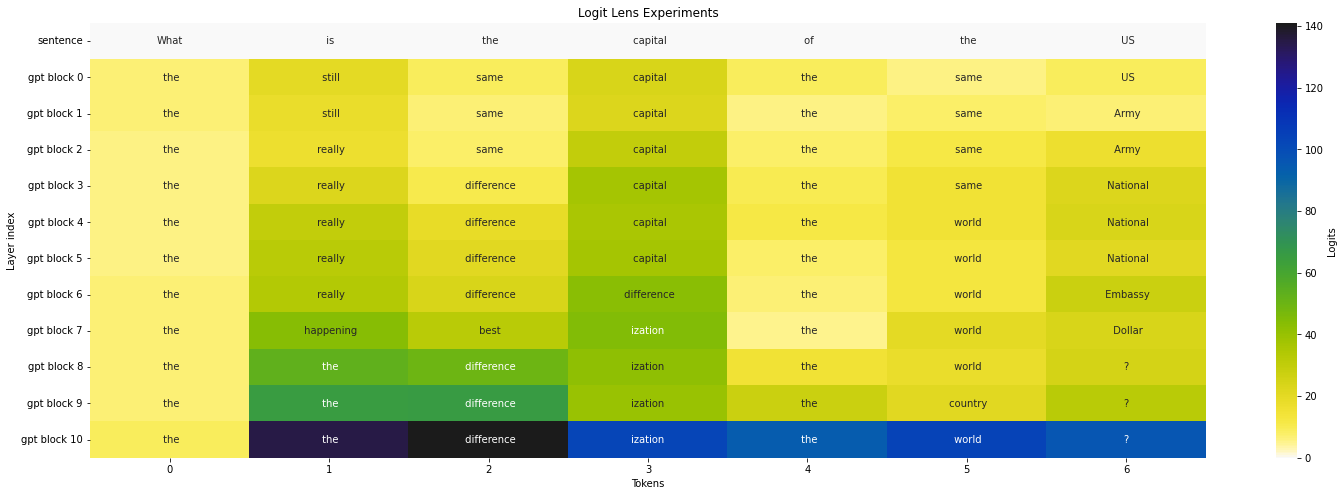

In [11]:
"""Final colored dataframe"""
fig, ax = plt.subplots(figsize=(25, 8))
ax = sns.heatmap(logits_df.astype(int), ax=ax, annot=words_df, 
                 cbar=True, fmt="", cmap=cc.kbgyw[::-1], 
                 linewidth=0.0, cbar_kws={'label': 'Logits'})
ax.set(title="Logit Lens Experiments", xlabel="Tokens", ylabel="Layer index",)
ax.xaxis.tick_bottom() 
ax.xaxis.set_label_position('bottom')
plt.show()

## Analysis of the results

In the explanation, we will use the term logits. The logits of a model are positive numbers representing the probability of belonging to the output class: the higher the logit, the more likely it is that the input will match the output. Logits are not probabilities because they can exceed 1. To pass from logits to probability it is necessary to apply the softmax function to logits for example.

The first salient information from the results is the inequality of confidence between the last layers and the first ones. Indeed, the first layers try to find correlated words while the last layer makes a decision. This gives an idea of the architecture of the gpt2 model.

The first column is also particular. The word "What" becomes "the". To understand this phenomenon we have to go back to the logits. The model is never sure what to put after. There is nothing in its memory, so it is hard to decide. So it decides to put a generalist word like "the".

Even though GPT-3 is presented as being much better than GPT-2, it already has some sentence comprehension skills. From "What is the", it confidently completes "difference" which is a likely follow-up. Then, from "What is the capital", it predicts that the sentence is "What is the capitalization" which is also a probable sentence. Finally, he understands that the sentence is a question because he predicts that the next word is a question mark. But it is clear that GPT-2 is far from the performance of GPT-3. If we write "I love hot chocolate with", GPT-2 predicts that the next word is "chocolate".